In [3]:
import numpy as np
from gr_pursuer.astar import astar2d
from gr_pursuer.agents.observer import Observer

from multigrid.envs.goal_prediction import GREnv

In [2]:
env = GREnv(size=32, agent_view_size=5, render_mode='human')
# env.agents[0].view_size = 5
env.reset()

# evader = Observer(env.agents[1], env.goal)
observations, infos = env.reset()
# observations = [{"grid": env.grid.state, "pos": agent.pos, "dir": agent.dir} 
#                    for agent in env.agents]

In [ ]:
grid = observations[0]["grid"][:, :, 0]
grid

In [ ]:
observations[0]["fov"][:,:,0]

In [ ]:
observations[1]["fov"][:,:,0]

In [ ]:
observations[1]["fov"][:,:,1]

In [ ]:
observations[0]["fov"][:,:,2]

In [ ]:
env.agents[0].see_through_walls

In [ ]:
grid = env.grid.state[:, :, 0]
cost = (grid==2).astype(int)*1000
path = astar2d(observations[1]["pos"], env.goal, cost)
path

In [ ]:
grid = env.grid.state[:, :, 0]
grid

In [29]:
cost = (grid==2).astype(int)*1000

In [ ]:
env.agents[0].dir

In [1]:
import numpy as np

In [ ]:
class Type(str, IndexedEnum):
    """
    Enumeration of object types.
    """
    unseen = 'unseen'
    empty = 'empty'
    wall = 'wall'
    floor = 'floor'
    door = 'door'
    key = 'key'
    ball = 'ball'
    box = 'box'
    goal = 'goal'
    lava = 'lava'
    agent = 'agent'

class WorldObjMeta(type):
    """
    Metaclass for world objects.

    Each subclass is associated with a unique :class:`Type` enumeration value.

    By default, the type name is the class name (in lowercase), but this can be
    overridden by setting the `type_name` attribute in the class definition.
    Type names are dynamically added to the :class:`Type` enumeration
    if not already present.

    Examples
    --------
    >>> class A(WorldObj): pass
    >>> A().type
    <Type.a: 'a'>

    >>> class B(WorldObj): type_name = 'goal'
    >>> B().type
    <Type.goal: 'goal'>

    :meta private:
    """

    # Registry of object classes
    _TYPE_IDX_TO_CLASS = {}

    def __new__(meta, name, bases, class_dict):
        cls = super().__new__(meta, name, bases, class_dict)

        if name != 'WorldObj':
            type_name = class_dict.get('type_name', name.lower())

            # Add the object class name to the `Type` enumeration if not already present
            if type_name not in set(Type):
                Type.add_item(type_name, type_name)

            # Store the object class with its corresponding type index
            meta._TYPE_IDX_TO_CLASS[Type(type_name).to_index()] = cls

        return cls

WorldObjMeta()
# obj = np.zeros(3, dtype=int).view(1)
# obj


In [ ]:
import random
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
from matplotlib import patches


def get_neighbours(coord, directions, size, cell_size):
    neighbours = [coord+dir for dir in directions[cell_size-1] 
                  if np.max(coord+dir) < size and np.min(coord+dir) >= 0]
    return neighbours

def unfill(grid, coord, size, cell_size):
    x1 = np.clip(coord[0], 1, size-1)
    x2 = np.clip(x1+cell_size, 1, size-1)
    y1 = np.clip(coord[1], 1, size-1)
    y2 = np.clip(y1+cell_size, 1, size-1)
    grid[x1:x2, y1:y2] = 0
    return grid

def position_agents(grid, init_sep, size):
    # Search for a random position where all the cells are unfilled in a initial_separation distance

    while True:
        #  np.where(grid == 0)
        row, col = np.where(grid == 0)
        idx = random.randint(0, len(row)-1)
        x, y = row[idx], col[idx]

        # Check if the col or row is empty
        if y+init_sep < size and (np.sum(grid[x, y:y+init_sep+1]) == 0):
            return [x, y], [x, y+init_sep]
        elif x+init_sep < size and (np.sum(grid[x:x+init_sep+1, y]) == 0):
            return [x, y], [x+init_sep, y]
        elif y-init_sep >= 0 and (np.sum(grid[x, y-init_sep:y]) == 0):
            return [x, y], [x, y-init_sep]
        elif x-init_sep >= 0 and (np.sum(grid[x-init_sep:x, y]) == 0):
            return [x, y], [x-init_sep, y]
        
def get_cost(grid, goals, target_pos):

    costs = []
    width, height = grid.shape

    for goal in goals:
        
        directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        queue = [(tuple(target_pos), 0)]
        visited = {tuple(target_pos): 1}
        
        while len(queue)>0:

            pos, cost = queue.pop(0)

            if pos == goal:
                costs.append(cost)
                break
            for dir in directions:
                new_pos = tuple(np.array(pos) + np.array(dir))
                # print(new_pos, goal, len(queue), len(visited.keys()))

                if not (new_pos in visited or grid[new_pos] != 0 or new_pos[0] >= width or new_pos[1] >= height or new_pos[0] < 0 or new_pos[1] < 0):
                    queue.append((new_pos, cost+1))
                    visited[new_pos] = 1
                
    return costs

directions = [[np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1])],
              [
                np.array([-1, 0]), np.array([-1, 1]), np.array([0, 2]), np.array([1, 2]), 
                np.array([2, 1]), np.array([2, 0]), np.array([0, -1]), np.array([1, -1])
               ]
              ]

size = 32
cell_size = 2
grid = np.ones((size, size), dtype=int)

#Choose 2 random points
start = np.random.randint(0, size//cell_size, 2)
grid = unfill(grid, start, size, cell_size)
explored = {tuple(start): 1}
queue = get_neighbours(start, directions, size, cell_size)

i = 0
while len(queue)>0:
    
    # idx = random.randint(0, len(queue)-1)
    idx = 3 if len(queue)>3 else 0
    cell = queue[idx]
    explored[tuple(cell)] = 1
    neighbours = get_neighbours(cell, directions, size, cell_size)
    filled_neighbours = [neighbour for neighbour in neighbours 
                         if grid[tuple(neighbour)] == 1]

    # The cell doesn't have 2 explored neighbours
    if ((cell_size==1) and (len(filled_neighbours) > 2) or (cell_size==2) and (len(filled_neighbours) > 2)):
        # grid[tuple(cell)] = 0
        grid = unfill(grid, cell, size, cell_size)
        queue += [neighbour for neighbour in filled_neighbours
                  if tuple(neighbour) not in explored]
        
    queue.pop(idx)
    # Change the cell size randomly
    cell_size = random.randint(1, 2) if cell[0]%2==0 and cell[1]%2==0 else 1

agent_pos, observer_pos = position_agents(grid, 4, size)
if grid[tuple(agent_pos)] == 1:
    print("Error: agent position is on a wall")
if grid[tuple(observer_pos)] == 1:
    print("Error: observer position is on a wall")

goals = []
for i in range(3):
    row, col = np.where(grid == 0)
    idx = random.randint(0, len(row)-1)
    x, y = row[idx], col[idx]
    goals.append((x, y))

print(goals)
print(get_cost(grid, goals, agent_pos))


agent_pos = tuple(agent_pos)
for goal in goals:
    grid[goal] = 3

grid[agent_pos] = 5
# grid[observer_pos)] = 20

goal_distance = np.zeros((size, size, len(goals)+1)) + size*2
# goal_distance[goal, :] = 0

points = goals + [agent_pos]
for i, point in enumerate(points):

    cell_size = 1
    queue = [(point, 0)]
    visited = {point: True}
    goal_distance[point[0], point[1], i] = 0

    while queue:

        pos, distance = queue.pop(0)

        neighbours = get_neighbours(pos, directions, size, cell_size)
        neighbours = [tuple(n) for n in neighbours]

        for n in neighbours:
            if n not in visited and grid[n]!=1:
                goal_distance[n[0], n[1], i] = distance+1
                queue.append((n, distance+1))
                visited[n] = True

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(grid, interpolation='nearest')
axs[1].imshow(goal_distance[:,:,0], interpolation='nearest')

In [ ]:
# import pprint
from collections import defaultdict

class PathGraph(object):
    """ Graph data structure, undirected by default. """

    def __init__(self, initial_pos, goal, grid, costs):
        self._graph = defaultdict(set)
        self.grid = grid
        self.costs = costs
        self.initial_pos = initial_pos
        self.goal = goal

        self.build()

    def build(self):
        """ Build the directed graph based in the grid """

        queue = [self.initial_pos]
        visited = {}

        i = 0
        while queue:
            i+=1

            pos = queue.pop()
            neighbours = self.get_neighbours(pos)

            for n in neighbours:
                if grid[n]!=1 and ((pos, n) not in visited or (n, pos) not in visited):

                    if self.costs[pos] >= self.costs[n]:
                        self.add(pos, n)
                    else:
                        self.add(n, pos)

                    if n not in queue:
                        queue.append(n)
                    visited[(pos, n)] = True

    def add(self, node1, node2):
        """ Add connection between node1 and node2 """

        self._graph[node1].add(node2)

    def get_neighbours(self, pos):
        
        directions = [
            [np.array([1, 0]), np.array([-1, 0]), np.array([0, 1]), np.array([0, -1])],
              [np.array([-1, 0]), np.array([-1, 1]), np.array([0, 2]), np.array([1, 2]), 
                np.array([2, 1]), np.array([2, 0]), np.array([0, -1]), np.array([1, -1])]]
        
        neighbours = [tuple(pos+dir) for dir in directions[cell_size-1] 
                  if np.max(pos+dir) < size and np.min(pos+dir) >= 0]
        
        return neighbours
        

    def remove(self, node):
        """ Remove all references to node """

        for n, cxns in self._graph.items():  # python3: items(); python2: iteritems()
            try:
                cxns.remove(node)
            except KeyError:
                pass
        try:
            del self._graph[node]
        except KeyError:
            pass

    def getShortestPath(self):

        path=[]
        pos = self.initial_pos
        while pos!=self.goal:
            adjs = list(self._graph[pos])
            best_idx = np.argmin([self.costs[adj] for adj in adjs])
            pos = adjs[best_idx]
            path.append(pos)

        return path

    def is_connected(self, node1, node2):
        """ Is node1 directly connected to node2 """

        return node1 in self._graph and node2 in self._graph[node1]

    def __str__(self):
        return '{}({})'.format(self.__class__.__name__, dict(self._graph))
    
    def plot(self):
        fig, axs = plt.subplots(1, 1, figsize=(10, 10))
        axs.imshow(grid, interpolation='nearest')

        for p1 in self._graph:
            for p2 in self._graph[p1]:
                x, y = tuple(zip(p1, p2))
                # axs.plot(y, x, 'r-', linewidth=1)
                axs.annotate(
                    "", xy=(y[1], x[1]), 
                    xytext=(y[0], x[0]),
                    arrowprops=dict(arrowstyle="->"))
                
        optimal_path = graph.getShortestPath()
        print(optimal_path)
        for i in range(0, len(optimal_path)-1, 1):
            p1 = optimal_path[i]
            p2 = optimal_path[i+1]
            x= [p1[1], p2[1]]
            y= [p1[0], p2[0]]
            axs.plot(x, y, 'r-', linewidth=1.5)
                
        plt.show()
    
graph = PathGraph(agent_pos, goals[0], grid, goal_distance[:,:,0])
graph.plot()

In [ ]:
grid2 = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

grid2 = np.array(grid2)


goals2 = [(3, 17), (9, 18), (10, 15), (8, 12), (5, 8), (4, 3), (17, 2), (17, 2)]
tmpgrid2 = grid2.copy()

for g in goals2:
    tmpgrid2[g] = 10

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(tmpgrid2, interpolation='nearest')

plt.show()

In [ ]:
from copy import deepcopy

def visibleFromCentroid(goal, coord, grid):
    # Bresenham’s Algorithm
    
    if grid[coord]==1:

        xmin = min(goal[0], coord[0])
        xmax = max(goal[0], coord[0])
        step = 0.1

        if (goal[0] - coord[0])!=0: 
            m = (goal[1] - coord[1]) / (goal[0] - coord[0]) 
            c = goal[1] - m*goal[0]

            x = np.arange(xmin, xmax+step, step)
            y = m*x + c


        else:

            
            ymin = min(goal[1], coord[1])
            ymax = max(goal[1], coord[1])
            y = np.arange(ymin, ymax+step, step)
            x = np.zeros(y.shape[0]) + goal[0]

        rows = tuple(np.round(x).astype(int).clip(0, size-1))
        cols = tuple(np.round(y).astype(int).clip(0, size-1))

        rows, cols = tuple(zip(*set(zip(rows, cols))))
        
        if sum(grid[rows, cols]) <= 1:
            return True
    
    return False
        
def bbox2polygon(bbox):
    pbbox = [p-0.5 for p in bbox]
    x1, y1, x2, y2 = pbbox
    vertices = [(y1, x1), (y1, x2), (y2, x2), (y2, x1)]
    return vertices

def updateRect(rect, coord, goal):
    
    x1, y1, x2, y2 = rect

    rect1=None
    if x1<=coord[0]<=x2:
        if coord[0]<=goal[0]:            
            rect1 = (coord[0], y1, x2, y2)
        else:
            rect1 = (x1, y1, coord[0], y2)

    rect2=None
    if y1<=coord[1]<=y2:
        if coord[1]<=goal[1]:
            rect2 = (x1, coord[1], x2, y2)
        else:
            rect2 = (x1, y1, x2, coord[1])


    if rect1 is None and rect2 is None:
        return rect

    if rect1 is not None:
        area1 = (rect1[2]-rect1[0])*(rect1[3]-rect1[1])
        if rect2 is None:
            return rect1

    if rect2 is not None:
        area2 = (rect2[2]-rect2[0])*(rect2[3]-rect2[1])
        if rect1 is None:
            return rect2

    if area2>area1:
        return rect2
    else:
        return rect1

landamarks = {}
rects = []
tmpgrid = np.copy(grid2)
for goal in goals2:
    size = grid2.shape[0]
    # x1 y1 x2 y2
    rect = [0, 0, size, size]
    visible = []
    
    for i in range(size):
        for j in range(size):
            coord = (i, j)
            if visibleFromCentroid(goal, coord, grid2):

                visible.append(coord)
                rect = updateRect(rect, coord, goal)
                # print(coord, rect, goal)
        
    rects.append(list(rect))
                

    
    tmpgrid[goal] = 10
    for coord in visible:
        tmpgrid[coord] = 5

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.imshow(tmpgrid, interpolation='nearest')

for rect in rects:
    vertices = bbox2polygon(rect)
    area_patch = patches.Polygon(vertices, edgecolor='r', facecolor='r', linewidth=0.5, fill=False)
    axs.add_patch(area_patch)

plt.show()

In [ ]:
# from  
from multigrid.core.constants import IDX_TO_OBJECT
IDX_TO_OBJECT

In [5]:
fov = np.array([[False,  True,  True,  True,  True],
 [False,  True,  True,  True,  True],
 [ True,  True,  True,  True,  True],
 [False, False, False,  True,  True],
 [False, False, False, False, False]]
)
fov

array([[False,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False, False]])

In [11]:
import numpy as np

In [ ]:
# from multigrid import 
import numpy as np
from multigrid.envs.goal_prediction import GREnv
env = GREnv(size=32, agent_view_size=5, render_mode='human')
# env.agents[0].view_size = 5
env.reset()

([{'fov': array([[[ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 2,  5,  0]],
   
          [[ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0]],
   
          [[10,  1,  1],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0],
           [ 1,  0,  0]],
   
          [[ 1,  0,  0],
           [ 1,  0,  0],
           [ 0,  0,  0],
           [ 2,  5,  0],
           [ 2,  5,  0]],
   
          [[ 0,  0,  0],
           [ 0,  0,  0],
           [ 1,  0,  0],
           [ 0,  0,  0],
           [ 1,  0,  0]]]),
   'grid': array([[[2, 5, 0],
           [2, 5, 0],
           [2, 5, 0],
           ...,
           [2, 5, 0],
           [2, 5, 0],
           [2, 5, 0]],
   
          [[2, 5, 0],
           [1, 0, 0],
           [2, 5, 0],
           ...,
           [2, 5, 0],
           [1, 0, 0],
           [2, 5, 0]],
   
          [[2, 5, 0],
         

In [7]:
from multigrid.utils.obs import gen_obs_grid_encoding, get_see_behind_mask, gen_obs_grid

image = gen_obs_grid_encoding(
            env.grid.state,
            env.agent_states,
            env.agents[0].view_size,
            env.agents[0].see_through_walls,
        )
obs_grid = gen_obs_grid(env.grid.state, env.agent_states, env.agents[0].view_size)

In [9]:
obs_grid.shape

(2, 5, 5, 3)

In [37]:
def visibleFromCentroid(agent_pos, coord, see_behind_mask):
    # Bresenham’s Algorithm
    see_behind_mask = (~see_behind_mask.astype(bool)).astype(int)
    width, height = see_behind_mask.shape[:2]
    xmin = min(agent_pos[0], coord[0])
    xmax = max(agent_pos[0], coord[0])
    step = 0.1

    if (agent_pos[0] - coord[0])!=0: 
        m = (agent_pos[1] - coord[1]) / (agent_pos[0] - coord[0]) 
        c = agent_pos[1] - m*agent_pos[0]

        x = np.arange(xmin, xmax+step, step)
        y = m*x + c


    else:
        ymin = min(agent_pos[1], coord[1])
        ymax = max(agent_pos[1], coord[1])
        y = np.arange(ymin, ymax+step, step)
        x = np.zeros(y.shape[0]) + agent_pos[0]

    rows = tuple(np.round(x).astype(int).clip(0, width-1))
    cols = tuple(np.round(y).astype(int).clip(0, width-1))

    rows, cols = tuple(zip(*set(zip(rows, cols))))

    print(coord)
    print(x, y)
    print(rows, cols)
    print(see_behind_mask[rows, cols])
    

    if sum(see_behind_mask[rows, cols]) == 0:
        return True

    return False


In [38]:

num_agents, width, height = obs_grid.shape[:3]
see_behind_mask = get_see_behind_mask(obs_grid)
vis_mask = np.zeros((num_agents, width, height), dtype=np.bool_)
vis_mask[:, width // 2, height - 1] = True # agent relative position

agent_pos = (width // 2, height - 1)
# print(agent_pos)
for agent in range(num_agents):
    for j in range(height):
        # Forward pass
        for i in range(width):
            coord = (i, j)
            vis_mask[agent, i, j] = visibleFromCentroid(
                agent_pos, coord, see_behind_mask[agent, :, :])

(0, 0)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2. ] [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4 2.6 2.8 3.  3.2 3.4
 3.6 3.8 4. ]
(0, 2, 1, 0, 1, 2, 1) (1, 4, 2, 0, 1, 3, 3)
[0 0 0 0 0 0 0]
(1, 0)
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ] [0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2 3.6 4. ]
(2, 1, 1, 2, 2, 1) (4, 2, 1, 3, 2, 0)
[0 0 0 0 0 0]
(2, 0)
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4. ]
(2, 2, 2, 2, 2) (4, 1, 0, 3, 2)
[0 0 0 0 0]
(3, 0)
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ] [ 4.00000000e+00  3.60000000e+00  3.20000000e+00  2.80000000e+00
  2.40000000e+00  2.00000000e+00  1.60000000e+00  1.20000000e+00
  8.00000000e-01  4.00000000e-01 -3.55271368e-15]
(2, 3, 3, 2, 2, 3) (4, 1, 0, 3

In [36]:
print(see_behind_mask[0, 3, 4])
# visibleFromCentroid(
#                 agent_pos, (3, 4), see_behind_mask[agent, :, :])

coord = (3, 4)
see_behind_mask_agent = see_behind_mask[0, :, :]
neg_see_behind_mask = (~see_behind_mask_agent.astype(bool)).astype(int)
width, height = see_behind_mask_agent.shape[:2]
xmin = min(agent_pos[0], coord[0])
xmax = max(agent_pos[0], coord[0])
step = 0.1

if (agent_pos[0] - coord[0])!=0: 
    m = (agent_pos[1] - coord[1]) / (agent_pos[0] - coord[0]) 
    c = agent_pos[1] - m*agent_pos[0]

    x = np.arange(xmin, xmax+step, step)
    y = m*x + c


else:
    ymin = min(agent_pos[1], coord[1])
    ymax = max(agent_pos[1], coord[1])
    y = np.arange(ymin, ymax+step, step)
    x = np.zeros(y.shape[0]) + agent_pos[0]

rows = tuple(np.round(x).astype(int).clip(0, width-1))
cols = tuple(np.round(y).astype(int).clip(0, width-1))

rows, cols = tuple(zip(*set(zip(rows, cols))))

print(coord)
print(x, y)
print(rows, cols)
print(neg_see_behind_mask[rows, cols])



False
(3, 4)
[2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ] [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
(2, 3) (4, 4)
[0 1]


In [35]:
width

2

In [34]:
np.round(x).astype(int)#.clip(0, width-1)

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3])

In [39]:
print(see_behind_mask)
print()
print(vis_mask)

[[[ True  True  True  True False]
  [ True  True  True  True  True]
  [ True  True  True  True  True]
  [ True  True False False False]
  [ True  True  True  True  True]]

 [[ True  True  True  True  True]
  [False False False  True  True]
  [ True  True  True  True  True]
  [ True  True  True  True  True]
  [False  True  True  True  True]]]

[[[ True  True  True  True False]
  [ True  True  True  True  True]
  [ True  True  True  True  True]
  [False False False False False]
  [False False False False False]]

 [[False False  True  True  True]
  [False False False  True  True]
  [ True  True  True  True  True]
  [ True  True  True  True  True]
  [False  True  True  True  True]]]


In [30]:
(~see_behind_mask.astype(bool)).astype(int)

array([[[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]]])

In [3]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '/home/crarojasca/Storage/Monash/DARPA/ANSR/EnvironmentCreation/customEnvironment/scenarioGenerator')

In [1]:
import numpy as np
import os
import cv2


from environmentMap import createEnvironmentMap

envDefinitionDir = "/home/crarojasca/Downloads/environmentMaps/CityPark"
environment_map = createEnvironmentMap(envDefinitionDir)

# spawnHeightCutOff = -20.0



# heightMaps = np.load(os.path.join(envDefinitionDir, "mosaicHeight.npz"))["mosaicHeight"]


# spawnHeightMaxMagnitude = 50.0
# heightMapSpawnableRegions = np.zeros([heightMaps.shape[0], heightMaps.shape[1], heightMaps.shape[2], 1], np.uint8)
# for i in range(heightMaps.shape[0]):
#     sobelX = cv2.Sobel(heightMaps[i, :, :, :], cv2.CV_32F, 1, 0, ksize=5)
#     sobelY = cv2.Sobel(heightMaps[i, :, :, :], cv2.CV_32F, 0, 1, ksize=5)
#     magnitude = sobelX ** 2 + sobelY ** 2

#     heightMapSpawnableRegions[i, :, :, :] = np.where(magnitude > spawnHeightMaxMagnitude, 0, 1).astype(np.uint8)[..., np.newaxis]
#     heightMapSpawnableRegions[i, :, :, :] = cv2.erode(heightMapSpawnableRegions[i, :, :], np.ones((3, 3), np.uint8), iterations=3)[..., np.newaxis]
# heightMapSpawnableRegions = np.where(heightMaps > spawnHeightCutOff, heightMapSpawnableRegions, 0).astype(np.uint8)


# heightMaps = heightMaps.transpose(1, 2, 3, 0)
# heightMaps = heightMaps.reshape([heightMaps.shape[0], heightMaps.shape[1], heightMaps.shape[3]])

ModuleNotFoundError: No module named 'environmentMap'

In [20]:
unique, counts = np.unique(np.round(environment_map.height), return_counts=True)
unique, counts 

(array([-2.42e+03, -6.00e+00, -1.00e+00, -0.00e+00,  1.00e+00,  2.00e+00,
         3.00e+00,  4.00e+00,  5.00e+00,  6.00e+00,  7.00e+00,  8.00e+00,
         9.00e+00,  1.00e+01,  1.10e+01,  1.20e+01,  1.30e+01,  1.40e+01,
         1.50e+01,  1.60e+01,  1.70e+01,  1.80e+01,  1.90e+01,  2.00e+01,
         2.10e+01,  2.20e+01,  2.30e+01,  2.40e+01,  2.50e+01,  2.60e+01,
         2.70e+01,  2.80e+01,  2.90e+01,  3.00e+01,  3.10e+01,  3.20e+01,
         3.30e+01,  3.40e+01,  3.50e+01,  3.60e+01,  3.70e+01,  3.80e+01,
         3.90e+01,  4.00e+01,  4.10e+01,  4.20e+01,  4.50e+01,  4.60e+01,
         4.70e+01,  5.30e+01,  6.00e+01,  6.10e+01,  6.20e+01,  6.30e+01,
         6.40e+01,  6.50e+01,  6.60e+01,  6.70e+01,  7.20e+01,  7.30e+01,
         7.40e+01,  7.70e+01,  7.90e+01,  8.00e+01,  8.10e+01,  8.50e+01,
         8.60e+01,  9.00e+01,  9.10e+01,  9.20e+01,  9.30e+01,  9.60e+01,
         9.80e+01,  9.90e+01,  1.07e+02,  1.08e+02,  1.11e+02,  1.12e+02,
         1.15e+02,  1.16e+02,  1.18e+0

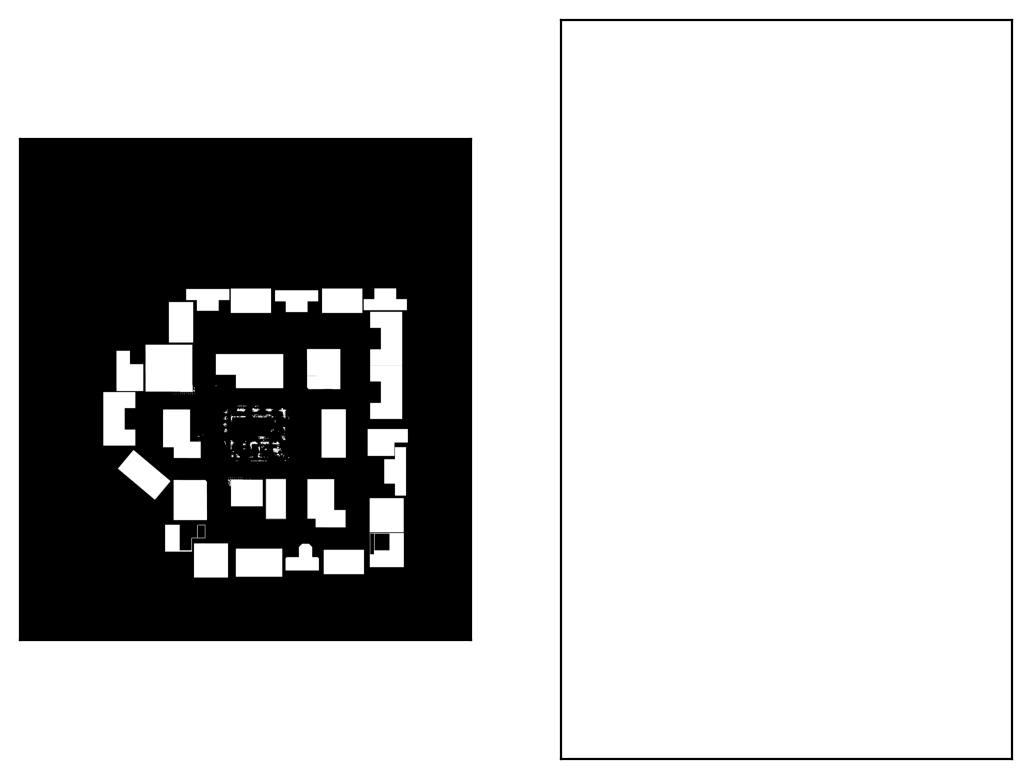

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

n=2
fig, axs = plt.subplots(1, n, dpi=200)  
map = np.logical_or(environment_map.height>0, environment_map.height<=16)
# map = environment_map.height>14, environment_map.height<=16
axs[0].imshow(environment_map.height.astype(int)>15, cmap='gray')
# axs[1].imshow(heightMapSpawnableRegions)
# Hide axis ticks
plt.setp(axs, xticks=[], yticks=[])
plt.show()